In [1]:
import keras
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Layer
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, Concatenate, Activation, Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import Callback, TensorBoard 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import RepeatVector, Permute
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave

import os
import random
import statistics
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Using TensorFlow backend.


In [2]:
# DATASET: https://www.kaggle.com/datasets/aayush9753/image-colorization-dataset

# Get images
train_path = './data/train_color/'
train_files = os.listdir(train_path)
target_size=(256,256)
#target_size=(64,64)

def ReadNormalizedRGBFromFile(path, filename, size):
    np_img = img_to_array(load_img(path+filename))
    np_img = resize(np_img, size)
    np_img = np.array(np_img, dtype=float)
    np_img = 1.0/255*np_img
    return np_img

demo_img = ReadNormalizedRGBFromFile(train_path, train_files[0], size=target_size)

In [3]:
#Load weights
if 'inception' not in locals():
    inception = InceptionResNetV2(weights="imagenet", include_top=True)
#inception.graph = tf.compat.v1.get_default_graph()

In [4]:
def SimplifiedModel(target_size):
    embed_input = Input(shape=(1000,))

    #Encoder
    encoder_input = Input(shape=target_size+(1,))
    encoder_output = Conv2D(32, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
    encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)

    #Fusion
    fusion_output = RepeatVector(encoder_output.shape[1] * encoder_output.shape[2])(embed_input) 
    fusion_output = Reshape(([encoder_output.shape[1], encoder_output.shape[2], 1000]))(fusion_output)
    fusion_output = Concatenate(axis=3)([encoder_output, fusion_output])
    fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output) 

    #Decoder
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)

    return Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

In [5]:
def FullModel(target_size):
    embed_input = Input(shape=(1000,))

    #Encoder
    encoder_input = Input(shape=target_size+(1,))
    encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
    encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

    #Fusion
    fusion_output = RepeatVector(encoder_output.shape[1] * encoder_output.shape[2])(embed_input) 
    fusion_output = Reshape(([encoder_output.shape[1], encoder_output.shape[2], 1000]))(fusion_output)
    fusion_output = Concatenate(axis=3)([encoder_output, fusion_output])
    fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output) 

    #Decoder
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)

    return Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

In [6]:
model = FullModel(target_size)
#model = SimplifiedModel(target_size)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 128, 128, 64) 640         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 128, 128, 128 73856       conv2d_203[0][0]                 
__________________________________________________________________________________________________
conv2d_205 (Conv2D)             (None, 64, 64, 128)  147584      conv2d_204[0][0]                 
_______________________________________________________________________________________

In [7]:
# Visualization/debugging
def Visualize(l, ab):
    plt.figure(figsize=(1,1))
    ab *= 128
    lab = np.dstack((l,ab[:,:,0],ab[:,:,1]))
    rgb = lab2rgb([lab])[0]
    plt.axis('off')
    plt.imshow(rgb)
    plt.show()

In [8]:
#Create embedding
def GetInceptionEmbedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (299, 299, 3), mode='constant')
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    embed = inception.predict(grayscaled_rgb_resized)
    return embed

def EvaluatePerformance(model, normalized_rgb): 
    gray = gray2rgb(rgb2gray([normalized_rgb]))
    embed = GetInceptionEmbedding(gray)
    gray_lab = rgb2lab(gray)[:,:,:,0]
    gray_lab = gray_lab.reshape(gray_lab.shape+(1,))
    predicted_ab = model.predict([gray_lab, embed])
    predicted_ab *= 128   
    predicted_lab = np.zeros(target_size+(3,))
    predicted_lab[:,:,0] = gray_lab[0][:,:,0]
    alt_gray = lab2rgb([predicted_lab])
    predicted_lab[:,:,1:] = predicted_ab[0]
    predicted_rgb = lab2rgb([predicted_lab])  
    
    w = 10
    h = 10
    columns = 3
    rows = 1
    fig = plt.figure(figsize=(8, 8))
    fig.add_subplot(rows, columns, 1)
    plt.axis('off')
    plt.imshow(normalized_rgb)
    fig.add_subplot(rows, columns, 2)
    plt.axis('off')
    plt.imshow(alt_gray[0])
    fig.add_subplot(rows, columns, 3)
    plt.axis('off')
    plt.imshow(predicted_rgb[0])
    plt.show()

In [9]:
# Data augmentation
import albumentations as A
import cv2

def Augmentor(img=None):
    transform = A.Compose([
        A.HorizontalFlip(always_apply=False, p=0.5),
        A.ShiftScaleRotate(always_apply=False, p=1.0, shift_limit=(-0.06, 0.06), scale_limit=(-0.1, 0.1), rotate_limit=(-45, 45), interpolation=0, border_mode=4),
    ])

    aug_img = transform(image=img)['image']
    
    return aug_img

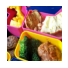

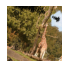

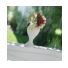

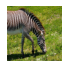

In [10]:
#Generate training data
def DataGenerator(path, filenames, batchsize, size):
    G = []
    X = []
    Y = []
    batchcount = 0
    while True:
        for f in filenames:
            rgb_img = ReadNormalizedRGBFromFile(path, f, size)
            aug_img = Augmentor(img=rgb_img)
            lab = rgb2lab([aug_img])[0]
            l = lab[:,:,:1]
            ab = lab[:,:,1:]
            ab /= 128
            G.append(gray2rgb(rgb2gray(rgb_img)))
            X.append(l)
            Y.append(ab)
            batchcount += 1
            if batchcount > batchsize:
              G = np.array(G, dtype='float32')
              X = [np.array(X, dtype='float32'), GetInceptionEmbedding(G)]
              Y = np.array(Y, dtype='float32')
              yield (X, Y)
              G = []
              X = []
              Y = []
              batchcount = 0
                
batch_size = 4
batch = next(DataGenerator(train_path, train_files, batch_size, target_size))
for i in range(batch_size):
    Visualize(batch[0][0][i], batch[1][i])

In [11]:
# Callbacks
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'model.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=0.00001)

class HowsItGoin(Callback):
  def on_epoch_end(self, epoch, logs=None):
    if epoch % 10 == 0:
        EvaluatePerformance(self.model, demo_img)
        
callbacks=[checkpoint, reduce_lr, HowsItGoin()]

Steps per epoch: 313
Epoch 1/200
313/313 [==============================] - ETA: 0s - loss: 0.0131 - accuracy: 0.6510WARNING:tensorflow:Can save best model only with val_loss available, skipping.


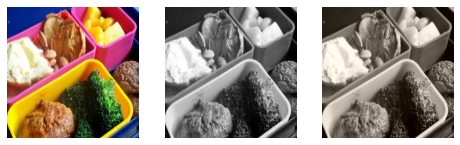

313/313 [==============================] - 996s 3s/step - loss: 0.0131 - accuracy: 0.6510
Epoch 2/200
313/313 [==============================] - 938s 3s/step - loss: 0.0129 - accuracy: 0.6525
Epoch 3/200
313/313 [==============================] - 889s 3s/step - loss: 0.0129 - accuracy: 0.6531
Epoch 4/200
313/313 [==============================] - 873s 3s/step - loss: 0.0129 - accuracy: 0.6525
Epoch 5/200
313/313 [==============================] - 894s 3s/step - loss: 0.0130 - accuracy: 0.6514
Epoch 6/200
313/313 [==============================] - 971s 3s/step - loss: 0.0130 - accuracy: 0.6517
Epoch 7/200
313/313 [==============================] - 910s 3s/step - loss: 0.0130 - accuracy: 0.6519
Epoch 8/200
313/313 [==============================] - 881s 3s/step - loss: 0.0129 - accuracy: 0.6509
Epoch 9/200
313/313 [==============================] - 878s 3s/step - loss: 0.0129 - accuracy: 0.6531
Epoch 10/200
313/313 [==============================] - 877s 3s/step - loss: 0.0129 - accuracy

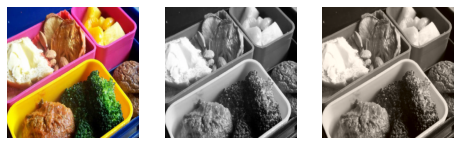

313/313 [==============================] - 933s 3s/step - loss: 0.0129 - accuracy: 0.6534
Epoch 12/200
313/313 [==============================] - 916s 3s/step - loss: 0.0130 - accuracy: 0.6532
Epoch 13/200
313/313 [==============================] - 875s 3s/step - loss: 0.0129 - accuracy: 0.6523
Epoch 14/200
313/313 [==============================] - 897s 3s/step - loss: 0.0129 - accuracy: 0.6529
Epoch 15/200
313/313 [==============================] - 893s 3s/step - loss: 0.0131 - accuracy: 0.6535
Epoch 16/200
313/313 [==============================] - 874s 3s/step - loss: 0.0130 - accuracy: 0.6520
Epoch 17/200
313/313 [==============================] - 856s 3s/step - loss: 0.0129 - accuracy: 0.6511
Epoch 18/200
313/313 [==============================] - 837s 3s/step - loss: 0.0129 - accuracy: 0.6520
Epoch 19/200
313/313 [==============================] - 839s 3s/step - loss: 0.0129 - accuracy: 0.6538
Epoch 20/200
313/313 [==============================] - 842s 3s/step - loss: 0.0130 - 

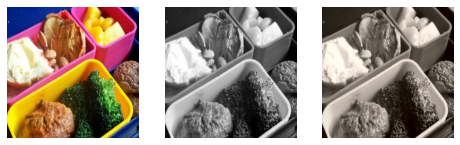

313/313 [==============================] - 845s 3s/step - loss: 0.0129 - accuracy: 0.6509
Epoch 22/200
313/313 [==============================] - 838s 3s/step - loss: 0.0130 - accuracy: 0.6517
Epoch 23/200
313/313 [==============================] - 840s 3s/step - loss: 0.0129 - accuracy: 0.6519
Epoch 24/200
313/313 [==============================] - 870s 3s/step - loss: 0.0129 - accuracy: 0.6518
Epoch 25/200
313/313 [==============================] - 843s 3s/step - loss: 0.0128 - accuracy: 0.6522
Epoch 26/200
313/313 [==============================] - 845s 3s/step - loss: 0.0127 - accuracy: 0.6540
Epoch 27/200
313/313 [==============================] - 843s 3s/step - loss: 0.0125 - accuracy: 0.6549
Epoch 28/200
313/313 [==============================] - 846s 3s/step - loss: 0.0124 - accuracy: 0.6558
Epoch 29/200
313/313 [==============================] - 845s 3s/step - loss: 0.0123 - accuracy: 0.6561
Epoch 30/200
313/313 [==============================] - 840s 3s/step - loss: 0.0122 - 

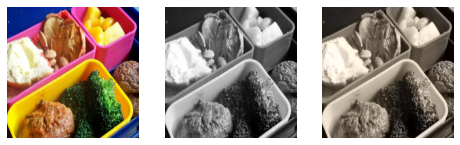

313/313 [==============================] - 846s 3s/step - loss: 0.0122 - accuracy: 0.6493
Epoch 32/200
313/313 [==============================] - 837s 3s/step - loss: 0.0121 - accuracy: 0.6486
Epoch 33/200
313/313 [==============================] - 839s 3s/step - loss: 0.0120 - accuracy: 0.6458
Epoch 34/200
313/313 [==============================] - 839s 3s/step - loss: 0.0120 - accuracy: 0.6465
Epoch 35/200
313/313 [==============================] - 847s 3s/step - loss: 0.0119 - accuracy: 0.6461
Epoch 36/200
313/313 [==============================] - 840s 3s/step - loss: 0.0121 - accuracy: 0.6451
Epoch 37/200
313/313 [==============================] - 843s 3s/step - loss: 0.0120 - accuracy: 0.6461
Epoch 38/200
313/313 [==============================] - 838s 3s/step - loss: 0.0119 - accuracy: 0.6453
Epoch 39/200
313/313 [==============================] - 837s 3s/step - loss: 0.0119 - accuracy: 0.6454
Epoch 40/200
313/313 [==============================] - 834s 3s/step - loss: 0.0119 - 

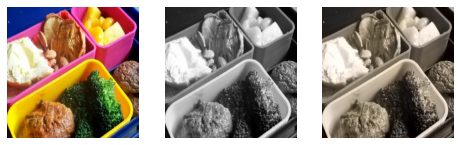

313/313 [==============================] - 839s 3s/step - loss: 0.0119 - accuracy: 0.6452
Epoch 42/200
313/313 [==============================] - 836s 3s/step - loss: 0.0118 - accuracy: 0.6459
Epoch 43/200
313/313 [==============================] - 839s 3s/step - loss: 0.0118 - accuracy: 0.6451
Epoch 44/200
313/313 [==============================] - 833s 3s/step - loss: 0.0118 - accuracy: 0.6463
Epoch 45/200
313/313 [==============================] - 837s 3s/step - loss: 0.0118 - accuracy: 0.6458
Epoch 46/200
313/313 [==============================] - 837s 3s/step - loss: 0.0120 - accuracy: 0.6460
Epoch 47/200
313/313 [==============================] - 839s 3s/step - loss: 0.0119 - accuracy: 0.6465
Epoch 48/200
313/313 [==============================] - 838s 3s/step - loss: 0.0118 - accuracy: 0.6444
Epoch 49/200
313/313 [==============================] - 834s 3s/step - loss: 0.0118 - accuracy: 0.6450
Epoch 50/200
313/313 [==============================] - 823s 3s/step - loss: 0.0118 - 

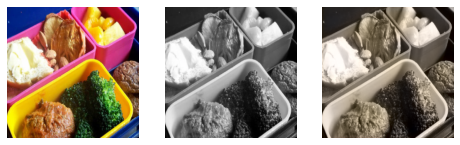

313/313 [==============================] - 833s 3s/step - loss: 0.0118 - accuracy: 0.6452
Epoch 52/200
313/313 [==============================] - 831s 3s/step - loss: 0.0118 - accuracy: 0.6443
Epoch 53/200
313/313 [==============================] - 829s 3s/step - loss: 0.0119 - accuracy: 0.6441
Epoch 54/200
313/313 [==============================] - 853s 3s/step - loss: 0.0118 - accuracy: 0.6447
Epoch 55/200
313/313 [==============================] - 852s 3s/step - loss: 0.0118 - accuracy: 0.6456
Epoch 56/200
313/313 [==============================] - 894s 3s/step - loss: 0.0118 - accuracy: 0.6456
Epoch 57/200
313/313 [==============================] - 871s 3s/step - loss: 0.0118 - accuracy: 0.6448
Epoch 58/200
313/313 [==============================] - 923s 3s/step - loss: 0.0117 - accuracy: 0.6448
Epoch 59/200
313/313 [==============================] - 879s 3s/step - loss: 0.0117 - accuracy: 0.6456
Epoch 60/200
313/313 [==============================] - 888s 3s/step - loss: 0.0117 - 

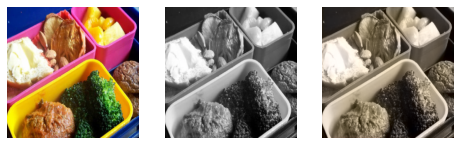

313/313 [==============================] - 879s 3s/step - loss: 0.0117 - accuracy: 0.6454
Epoch 62/200
313/313 [==============================] - 882s 3s/step - loss: 0.0119 - accuracy: 0.6446
Epoch 63/200
313/313 [==============================] - 864s 3s/step - loss: 0.0118 - accuracy: 0.6456
Epoch 64/200
313/313 [==============================] - 901s 3s/step - loss: 0.0117 - accuracy: 0.6457
Epoch 65/200
313/313 [==============================] - 905s 3s/step - loss: 0.0117 - accuracy: 0.6441
Epoch 66/200
313/313 [==============================] - 829s 3s/step - loss: 0.0117 - accuracy: 0.6454
Epoch 67/200
313/313 [==============================] - 853s 3s/step - loss: 0.0118 - accuracy: 0.6444
Epoch 68/200
313/313 [==============================] - 823s 3s/step - loss: 0.0118 - accuracy: 0.6451
Epoch 69/200
313/313 [==============================] - 2577s 8s/step - loss: 0.0117 - accuracy: 0.6439
Epoch 70/200
313/313 [==============================] - 784s 3s/step - loss: 0.0117 -

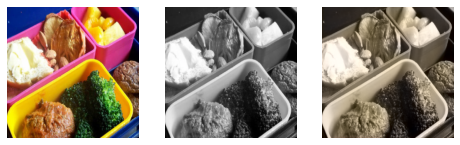

313/313 [==============================] - 768s 2s/step - loss: 0.0118 - accuracy: 0.6462
Epoch 72/200
313/313 [==============================] - 753s 2s/step - loss: 0.0117 - accuracy: 0.6445
Epoch 73/200
313/313 [==============================] - 751s 2s/step - loss: 0.0117 - accuracy: 0.6462
Epoch 74/200
313/313 [==============================] - 758s 2s/step - loss: 0.0117 - accuracy: 0.6445
Epoch 75/200
313/313 [==============================] - 755s 2s/step - loss: 0.0117 - accuracy: 0.6454
Epoch 76/200
313/313 [==============================] - 756s 2s/step - loss: 0.0117 - accuracy: 0.6450
Epoch 77/200
313/313 [==============================] - 769s 2s/step - loss: 0.0118 - accuracy: 0.6457
Epoch 78/200
313/313 [==============================] - 763s 2s/step - loss: 0.0118 - accuracy: 0.6455
Epoch 79/200
313/313 [==============================] - 762s 2s/step - loss: 0.0117 - accuracy: 0.6450
Epoch 80/200
313/313 [==============================] - 774s 2s/step - loss: 0.0116 - 

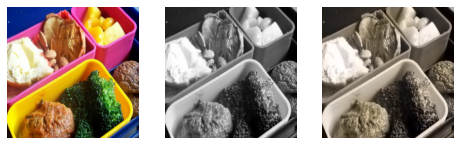

313/313 [==============================] - 778s 2s/step - loss: 0.0117 - accuracy: 0.6455
Epoch 82/200
313/313 [==============================] - 759s 2s/step - loss: 0.0117 - accuracy: 0.6454
Epoch 83/200
313/313 [==============================] - 763s 2s/step - loss: 0.0117 - accuracy: 0.6443
Epoch 84/200
313/313 [==============================] - 759s 2s/step - loss: 0.0117 - accuracy: 0.6446
Epoch 85/200
313/313 [==============================] - 766s 2s/step - loss: 0.0117 - accuracy: 0.6454
Epoch 86/200
313/313 [==============================] - 762s 2s/step - loss: 0.0116 - accuracy: 0.6448
Epoch 87/200
313/313 [==============================] - 768s 2s/step - loss: 0.0117 - accuracy: 0.6459
Epoch 88/200
313/313 [==============================] - 769s 2s/step - loss: 0.0117 - accuracy: 0.6452
Epoch 89/200
313/313 [==============================] - 775s 2s/step - loss: 0.0116 - accuracy: 0.6450
Epoch 90/200
313/313 [==============================] - 773s 2s/step - loss: 0.0116 - 

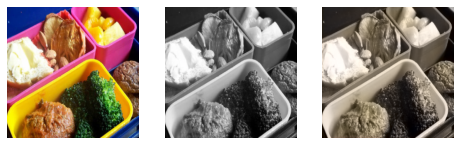

313/313 [==============================] - 764s 2s/step - loss: 0.0116 - accuracy: 0.6457
Epoch 92/200
313/313 [==============================] - 776s 2s/step - loss: 0.0116 - accuracy: 0.6459
Epoch 93/200
313/313 [==============================] - 765s 2s/step - loss: 0.0118 - accuracy: 0.6461
Epoch 94/200
313/313 [==============================] - 772s 2s/step - loss: 0.0117 - accuracy: 0.6455
Epoch 95/200
313/313 [==============================] - 795s 3s/step - loss: 0.0116 - accuracy: 0.6455
Epoch 96/200
313/313 [==============================] - 767s 2s/step - loss: 0.0116 - accuracy: 0.6453
Epoch 97/200
313/313 [==============================] - 1490s 5s/step - loss: 0.0116 - accuracy: 0.6460
Epoch 98/200
313/313 [==============================] - 813s 3s/step - loss: 0.0117 - accuracy: 0.6442
Epoch 99/200
313/313 [==============================] - 812s 3s/step - loss: 0.0116 - accuracy: 0.6455
Epoch 100/200
313/313 [==============================] - 842s 3s/step - loss: 0.0117 

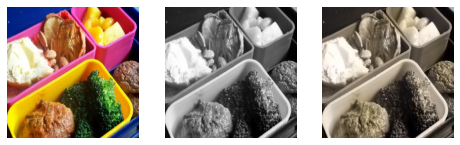

313/313 [==============================] - 889s 3s/step - loss: 0.0116 - accuracy: 0.6443
Epoch 102/200
313/313 [==============================] - 828s 3s/step - loss: 0.0116 - accuracy: 0.6464
Epoch 103/200
313/313 [==============================] - 809s 3s/step - loss: 0.0116 - accuracy: 0.6460
Epoch 104/200
313/313 [==============================] - 2361s 8s/step - loss: 0.0115 - accuracy: 0.6469
Epoch 105/200
313/313 [==============================] - 851s 3s/step - loss: 0.0116 - accuracy: 0.6448
Epoch 106/200
313/313 [==============================] - 805s 3s/step - loss: 0.0116 - accuracy: 0.6459
Epoch 107/200
313/313 [==============================] - 796s 3s/step - loss: 0.0115 - accuracy: 0.6448
Epoch 108/200
313/313 [==============================] - 794s 3s/step - loss: 0.0116 - accuracy: 0.6447
Epoch 109/200
313/313 [==============================] - 808s 3s/step - loss: 0.0117 - accuracy: 0.6454
Epoch 110/200
313/313 [==============================] - 852s 3s/step - loss:

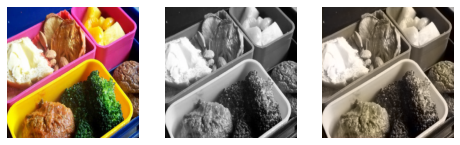

313/313 [==============================] - 877s 3s/step - loss: 0.0115 - accuracy: 0.6452
Epoch 112/200
313/313 [==============================] - 844s 3s/step - loss: 0.0115 - accuracy: 0.6449
Epoch 113/200
313/313 [==============================] - 809s 3s/step - loss: 0.0115 - accuracy: 0.6448
Epoch 114/200
313/313 [==============================] - 806s 3s/step - loss: 0.0117 - accuracy: 0.6444
Epoch 115/200
313/313 [==============================] - 805s 3s/step - loss: 0.0116 - accuracy: 0.6459
Epoch 116/200
313/313 [==============================] - 803s 3s/step - loss: 0.0115 - accuracy: 0.6451
Epoch 117/200
313/313 [==============================] - 801s 3s/step - loss: 0.0115 - accuracy: 0.6447
Epoch 118/200
313/313 [==============================] - 801s 3s/step - loss: 0.0115 - accuracy: 0.6461
Epoch 119/200
313/313 [==============================] - 807s 3s/step - loss: 0.0116 - accuracy: 0.6448
Epoch 120/200
313/313 [==============================] - 805s 3s/step - loss: 

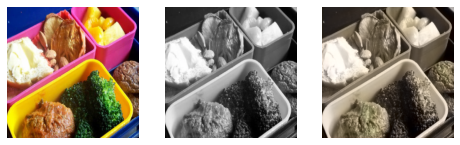

313/313 [==============================] - 803s 3s/step - loss: 0.0115 - accuracy: 0.6454
Epoch 122/200
313/313 [==============================] - 804s 3s/step - loss: 0.0114 - accuracy: 0.6463
Epoch 123/200
313/313 [==============================] - 799s 3s/step - loss: 0.0115 - accuracy: 0.6462
Epoch 124/200
313/313 [==============================] - 801s 3s/step - loss: 0.0116 - accuracy: 0.6469
Epoch 125/200
313/313 [==============================] - 813s 3s/step - loss: 0.0115 - accuracy: 0.6468
Epoch 126/200
313/313 [==============================] - 810s 3s/step - loss: 0.0115 - accuracy: 0.6475
Epoch 127/200
313/313 [==============================] - 806s 3s/step - loss: 0.0115 - accuracy: 0.6472
Epoch 128/200
313/313 [==============================] - 805s 3s/step - loss: 0.0115 - accuracy: 0.6492
Epoch 129/200
313/313 [==============================] - 833s 3s/step - loss: 0.0115 - accuracy: 0.6480
Epoch 130/200
313/313 [==============================] - 810s 3s/step - loss: 

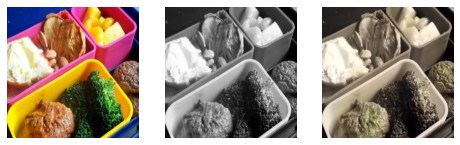

313/313 [==============================] - 806s 3s/step - loss: 0.0115 - accuracy: 0.6491
Epoch 132/200
313/313 [==============================] - 811s 3s/step - loss: 0.0114 - accuracy: 0.6491
Epoch 133/200
313/313 [==============================] - 807s 3s/step - loss: 0.0115 - accuracy: 0.6508
Epoch 134/200
313/313 [==============================] - 805s 3s/step - loss: 0.0115 - accuracy: 0.6513
Epoch 135/200
313/313 [==============================] - 799s 3s/step - loss: 0.0114 - accuracy: 0.6504
Epoch 136/200
313/313 [==============================] - 796s 3s/step - loss: 0.0114 - accuracy: 0.6501
Epoch 137/200
313/313 [==============================] - 799s 3s/step - loss: 0.0114 - accuracy: 0.6516
Epoch 138/200
313/313 [==============================] - 797s 3s/step - loss: 0.0114 - accuracy: 0.6516
Epoch 139/200
313/313 [==============================] - 799s 3s/step - loss: 0.0114 - accuracy: 0.6525
Epoch 140/200
313/313 [==============================] - 795s 3s/step - loss: 

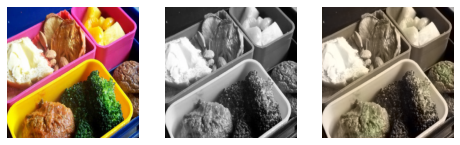

313/313 [==============================] - 798s 3s/step - loss: 0.0114 - accuracy: 0.6530
Epoch 142/200
313/313 [==============================] - 792s 3s/step - loss: 0.0113 - accuracy: 0.6527
Epoch 143/200
313/313 [==============================] - 804s 3s/step - loss: 0.0113 - accuracy: 0.6531
Epoch 144/200
313/313 [==============================] - 807s 3s/step - loss: 0.0113 - accuracy: 0.6537
Epoch 145/200
313/313 [==============================] - 804s 3s/step - loss: 0.0114 - accuracy: 0.6529
Epoch 146/200
313/313 [==============================] - 804s 3s/step - loss: 0.0113 - accuracy: 0.6527
Epoch 147/200
313/313 [==============================] - 813s 3s/step - loss: 0.0113 - accuracy: 0.6520
Epoch 148/200
313/313 [==============================] - 817s 3s/step - loss: 0.0113 - accuracy: 0.6520
Epoch 149/200
313/313 [==============================] - 820s 3s/step - loss: 0.0113 - accuracy: 0.6541
Epoch 150/200
313/313 [==============================] - 820s 3s/step - loss: 

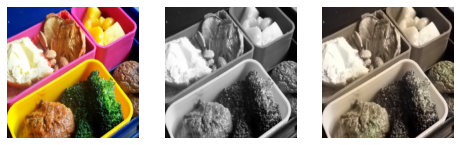

313/313 [==============================] - 812s 3s/step - loss: 0.0112 - accuracy: 0.6538
Epoch 152/200
313/313 [==============================] - 812s 3s/step - loss: 0.0112 - accuracy: 0.6525
Epoch 153/200
313/313 [==============================] - 834s 3s/step - loss: 0.0112 - accuracy: 0.6537
Epoch 154/200
313/313 [==============================] - 825s 3s/step - loss: 0.0112 - accuracy: 0.6520
Epoch 155/200
313/313 [==============================] - 833s 3s/step - loss: 0.0113 - accuracy: 0.6535
Epoch 156/200
313/313 [==============================] - 829s 3s/step - loss: 0.0113 - accuracy: 0.6532
Epoch 157/200
313/313 [==============================] - 857s 3s/step - loss: 0.0112 - accuracy: 0.6532
Epoch 158/200
313/313 [==============================] - 847s 3s/step - loss: 0.0111 - accuracy: 0.6526
Epoch 159/200
313/313 [==============================] - 852s 3s/step - loss: 0.0112 - accuracy: 0.6541
Epoch 160/200
313/313 [==============================] - 844s 3s/step - loss: 

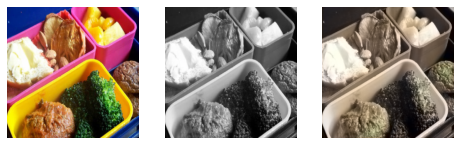

313/313 [==============================] - 864s 3s/step - loss: 0.0112 - accuracy: 0.6530
Epoch 162/200
313/313 [==============================] - 878s 3s/step - loss: 0.0113 - accuracy: 0.6526
Epoch 163/200
313/313 [==============================] - 872s 3s/step - loss: 0.0111 - accuracy: 0.6538
Epoch 164/200
313/313 [==============================] - 860s 3s/step - loss: 0.0111 - accuracy: 0.6560
Epoch 165/200
313/313 [==============================] - 867s 3s/step - loss: 0.0111 - accuracy: 0.6550
Epoch 166/200
313/313 [==============================] - 867s 3s/step - loss: 0.0111 - accuracy: 0.6547
Epoch 167/200
313/313 [==============================] - 869s 3s/step - loss: 0.0111 - accuracy: 0.6543
Epoch 168/200
313/313 [==============================] - 858s 3s/step - loss: 0.0111 - accuracy: 0.6561
Epoch 169/200
313/313 [==============================] - 858s 3s/step - loss: 0.0111 - accuracy: 0.6561
Epoch 170/200
313/313 [==============================] - 859s 3s/step - loss: 

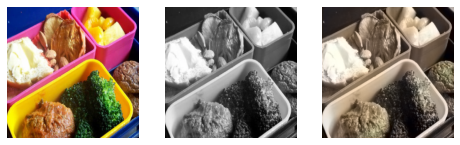

313/313 [==============================] - 860s 3s/step - loss: 0.0112 - accuracy: 0.6550
Epoch 172/200
313/313 [==============================] - 862s 3s/step - loss: 0.0112 - accuracy: 0.6559
Epoch 173/200
313/313 [==============================] - 857s 3s/step - loss: 0.0110 - accuracy: 0.6552
Epoch 174/200
313/313 [==============================] - 857s 3s/step - loss: 0.0111 - accuracy: 0.6558
Epoch 175/200
313/313 [==============================] - 857s 3s/step - loss: 0.0110 - accuracy: 0.6562
Epoch 176/200
313/313 [==============================] - 858s 3s/step - loss: 0.0111 - accuracy: 0.6562
Epoch 177/200
313/313 [==============================] - 860s 3s/step - loss: 0.0111 - accuracy: 0.6563
Epoch 178/200
313/313 [==============================] - 876s 3s/step - loss: 0.0111 - accuracy: 0.6555
Epoch 179/200
313/313 [==============================] - 863s 3s/step - loss: 0.0111 - accuracy: 0.6546
Epoch 180/200
313/313 [==============================] - 859s 3s/step - loss: 

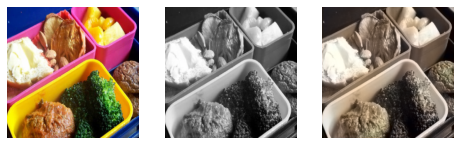

313/313 [==============================] - 867s 3s/step - loss: 0.0111 - accuracy: 0.6553
Epoch 182/200
313/313 [==============================] - 868s 3s/step - loss: 0.0110 - accuracy: 0.6570
Epoch 183/200
313/313 [==============================] - 866s 3s/step - loss: 0.0110 - accuracy: 0.6567
Epoch 184/200
313/313 [==============================] - 863s 3s/step - loss: 0.0110 - accuracy: 0.6573
Epoch 185/200
313/313 [==============================] - 867s 3s/step - loss: 0.0110 - accuracy: 0.6569
Epoch 186/200
313/313 [==============================] - 869s 3s/step - loss: 0.0111 - accuracy: 0.6572
Epoch 187/200
313/313 [==============================] - 862s 3s/step - loss: 0.0111 - accuracy: 0.6570
Epoch 188/200
313/313 [==============================] - 859s 3s/step - loss: 0.0110 - accuracy: 0.6560
Epoch 189/200
313/313 [==============================] - 866s 3s/step - loss: 0.0110 - accuracy: 0.6578
Epoch 190/200
313/313 [==============================] - 871s 3s/step - loss: 

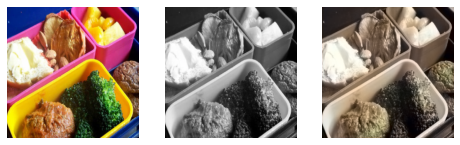

313/313 [==============================] - 874s 3s/step - loss: 0.0110 - accuracy: 0.6578
Epoch 192/200
313/313 [==============================] - 881s 3s/step - loss: 0.0111 - accuracy: 0.6571
Epoch 193/200
313/313 [==============================] - 867s 3s/step - loss: 0.0111 - accuracy: 0.6572
Epoch 194/200
313/313 [==============================] - 881s 3s/step - loss: 0.0110 - accuracy: 0.6561
Epoch 195/200
313/313 [==============================] - 892s 3s/step - loss: 0.0110 - accuracy: 0.6566
Epoch 196/200
313/313 [==============================] - 871s 3s/step - loss: 0.0110 - accuracy: 0.6571
Epoch 197/200
313/313 [==============================] - 880s 3s/step - loss: 0.0110 - accuracy: 0.6564
Epoch 198/200
313/313 [==============================] - 866s 3s/step - loss: 0.0109 - accuracy: 0.6566
Epoch 199/200
313/313 [==============================] - 827s 3s/step - loss: 0.0109 - accuracy: 0.6579
Epoch 200/200
313/313 [==============================] - 831s 3s/step - loss: 

In [13]:
#Train model
batch_size = 16

model.compile(optimizer='adam', loss='mse', metrics='accuracy')

steps = int(np.ceil(len(train_files)/batch_size))
print(f"Steps per epoch: {steps}")

history = model.fit(
    DataGenerator(train_path, train_files, batch_size, target_size),
    callbacks=callbacks,
    epochs=200,
    steps_per_epoch=steps)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


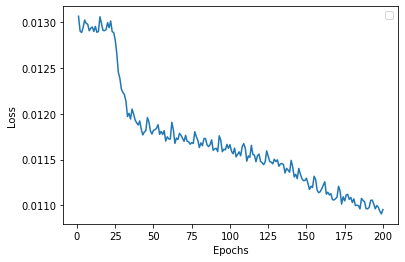

In [26]:
values = history.history['loss']
epochs_range = range(1, len(loss_values)+1)

plt.plot(epochs_range, values)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


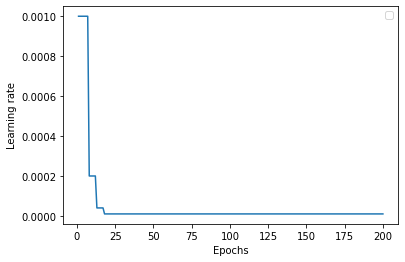

In [27]:
values = history.history['lr']

plt.plot(epochs_range, values)
plt.xlabel('Epochs')
plt.ylabel('Learning rate')
plt.legend()

plt.show()

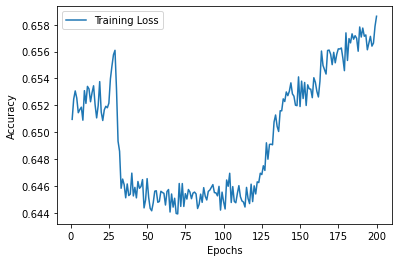

In [28]:
values = history.history['accuracy']

plt.plot(epochs_range, values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [15]:
#Make a prediction on the unseen images
test_path = './data/test_color/'
test_files = os.listdir(test_path)[:10]
color_me = []
for filename in test_files:
    np_img = img_to_array(load_img(test_path+filename))
    np_img = resize(np_img, (256, 256))
    color_me.append(np_img)
color_me = np.array(color_me, dtype=float)
color_me = 1.0/255*color_me 
color_me = gray2rgb(rgb2gray(color_me))
color_me_embed = GetInceptionEmbedding(color_me)
color_me = rgb2lab(color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))  

In [16]:
# Test model
output = model.predict([color_me, color_me_embed])
output = output * 128

In [17]:
# Output colorizations
for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = color_me[i][:,:,0]
    cur[:,:,1:] = output[i]
    imsave("result/img_"+str(i)+".png", lab2rgb(cur))

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0